In [1]:
import numpy as np
import scipy as scp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
from numba import cuda

import os
import glob
import time
import IPython.display

from lat_class import *
"""
from tqdm.notebook import tqdm
"""

'\nfrom tqdm.notebook import tqdm\n'

In [2]:
kl_sim = lattice_sim()

[2 2 3 3]


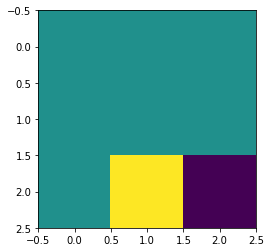

before extend: head: [2 1], tail: [2 2]
proposing dir_i 0
proposing sign 1
possibly invalid link index: [0 2 1]
valid link index: [0 1 1]
proposing move 2
proposing move [-1  0]
prop_head [1 1]
k change 1
k_old 0
k_change 1
k_prop 1
k change 1
p 1.0
accepted
updating links[[0 1 1]] += 1
updating f[[2 1]] += 2
head [2 1]
prop_head [1 1]
updating f[[1 1]] += 2
after extend: head: [1 1], tail: [2 2]


In [ ]:
"""main worm loop"""
#num_iter = 20
update_obs_worms = 5

n_worms = 0
max_n_worms = 5

#randomnly initialize rand_delta
#rand_delta = np.random.choice([-1,1])
#rand_delta = np.sign(np.random.randint(-1,1))
rand_delta = np.random.randint(0,1)*2 - 1
print(f"rand value: {rand_delta}")

"""cant access df from function!!"""
#change in f to be kept track of



#limit the number of iteration/worms
#for i in range(num_iter):
    #print(f"Iteration {i}")
while n_worms < max_n_worms:
    print(f"f {kl_sim.f}")
    print(f"k {kl_sim.k_links}")
    
    #print the position of the worms head and tail
    kl_sim.print_env_worm(kl_sim.lat_size, kl_sim.head, kl_sim.tail)
    print(f"before extend: head: {kl_sim.head}, tail: {kl_sim.tail}")
    
    #worm has not yet started
    started = False
    #repeatedly propose moves until one of them gets accepted
    while started == False:
        #randomly chooses a move
        #that is
        #dir_i [0,dim)
        #sign [0,1]
        #dir_i is written into worm_link_coord[0]
        print(f"prop_head {kl_sim.prop_head}")
        
        #kl_sim.propose_move(kl_sim.dir_i, kl_sim.sign, kl_sim.move_i, kl_sim.move_set, kl_sim.head, kl_sim.prop_head, kl_sim.worm_link_coord, kl_sim.k_delta, kl_sim.k_change, kl_sim.lat_size, kl_sim.dim)
        kl_sim.propose_move(kl_sim.dir_i, kl_sim.sign, kl_sim.move_i, kl_sim.move_set, kl_sim.head, kl_sim.prop_head, kl_sim.worm_link_coord, kl_sim.k_delta, kl_sim.changes, kl_sim.lat_size, kl_sim.dim)
        
        
        #get acceptance probability
        #p = kl_sim.get_prob_k(kl_sim.l_links, kl_sim.k_links, kl_sim.mu, kl_sim.head, kl_sim.prop_head, kl_sim.tail, kl_sim.worm_link_coord, kl_sim.k_change, kl_sim.W, kl_sim.f, kl_sim.df)
        p = kl_sim.get_prob_k(kl_sim.l_links, kl_sim.k_links, kl_sim.mu, kl_sim.head, kl_sim.prop_head, kl_sim.tail, kl_sim.worm_link_coord, kl_sim.changes, kl_sim.W, kl_sim.f)
        p = 1.
        print(f"p {p}")

        #accept or reject move
        if np.random.uniform() < p:
            print("accepted")
            #accept
            #update links
            kl_sim.update_link(kl_sim.k_links, kl_sim.worm_link_coord, kl_sim.changes[2])
            
            #dont update f at the start so that f is even
            #but store the value for later
            kl_sim.changes[0] = kl_sim.changes[1]
            
            #extend head
            #kl_sim.extend(kl_sim.head, kl_sim.worm_link_coord, kl_sim.move_i, kl_sim.move_set, kl_sim.lat_size, kl_sim.dim)
            kl_sim.set_head(kl_sim.head, kl_sim.prop_head)

            #update f at new site!
            #kl_sim.update_f_df(kl_sim.f, kl_sim.head, kl_sim.df)
            kl_sim.update_f_df(kl_sim.f, kl_sim.head, kl_sim.changes[1])

            print(f"after extend: head: {kl_sim.head}, tail: {kl_sim.tail}")
            started = True
        else:
            #reject
            print("rejected")
    
    print("starting worm")
    input("Press Enter to continue...") 
    time.sleep(1.0)
    IPython.display.clear_output(wait=True)
    
    #run the worm while it forms an open path
    while not kl_sim.check_head_tail(kl_sim.head, kl_sim.tail):
        
        kl_sim.print_env_worm(kl_sim.lat_size, kl_sim.head, kl_sim.tail)
        print(f"before extend: head: {kl_sim.head}, tail: {kl_sim.tail}")
        
        #move_i = propose_move(n_moves_gpu)
        #randomly chooses a move
        #that is
        #dir_i [0,dim)
        #sign [0,1]
        """not updating k_change in class!!!"""
        kl_sim.propose_move(kl_sim.dir_i, kl_sim.sign, kl_sim.move_i, kl_sim.move_set, kl_sim.head, kl_sim.prop_head, kl_sim.worm_link_coord, kl_sim.k_delta, kl_sim.changes, kl_sim.lat_size, kl_sim.dim)
        
        #get acceptance probability
        """kchange has defautl value!!!"""
        #p = kl_sim.get_prob_k(kl_sim.l_links, kl_sim.k_links, kl_sim.mu, kl_sim.head, kl_sim.prop_head, kl_sim.tail, kl_sim.worm_link_coord, kl_sim.k_change, kl_sim.W, kl_sim.f, kl_sim.df)
        p = kl_sim.get_prob_k(kl_sim.l_links, kl_sim.k_links, kl_sim.mu, kl_sim.head, kl_sim.prop_head, kl_sim.tail, kl_sim.worm_link_coord, kl_sim.changes, kl_sim.W, kl_sim.f)
        p = 1.
        print(f"p {p}")

        #accept or reject move
        if np.random.uniform() < p:
            print("accepted")
            #accept
            #update links
            kl_sim.update_link(kl_sim.k_links, kl_sim.worm_link_coord, kl_sim.changes[2])

            #update f at old site!
            #kl_sim.update_f_df(kl_sim.f, kl_sim.head, kl_sim.df)
            kl_sim.update_f_df(kl_sim.f, kl_sim.head, kl_sim.changes[1])

            #extend head
            #kl_sim.extend(kl_sim.head, kl_sim.worm_link_coord, kl_sim.move_i, kl_sim.move_set, kl_sim.lat_size, kl_sim.dim)
            kl_sim.set_head(kl_sim.head, kl_sim.prop_head)

            #update f at new site!
            #kl_sim.update_f_df(kl_sim.f, kl_sim.head, kl_sim.df)
            kl_sim.update_f_df(kl_sim.f, kl_sim.head, kl_sim.changes[1])

            print(f"after extend: head: {kl_sim.head}, tail: {kl_sim.tail}")
        else:
            #reject
            print("rejected")
            
        input("Press Enter to continue...")
        time.sleep(1.0)
        IPython.display.clear_output(wait=True)
    
    
    print("Tail = Head!")
    kl_sim.print_env_worm(kl_sim.lat_size, kl_sim.head, kl_sim.tail)

    #worm about to close
    #update f with initial df0
    #kl_sim.update_f_df(kl_sim.f, kl_sim.head, kl_sim.df0)
    kl_sim.update_f_df(kl_sim.f, kl_sim.head, kl_sim.changes[0])

    #reset the worm randomly
    kl_sim.reset_worm(kl_sim.tail, kl_sim.head, kl_sim.worm_link_coord, kl_sim.lat_size, kl_sim.dim)

    #reinitialize rand_delta randomly
    #rand_delta = np.random.choice([-1,1])
    #rand_delta = np.sign(np.random.randint(-1,1))

    #keep track of the number of worms
    n_worms += 1
    print(f"nworms {n_worms}")
    
    #update the observable each update_obs_worms
    if n_worms%update_obs_worms == 0:
        observable += update_obs(lat_links)
        
    input("Press Enter to continue...")
    time.sleep(1.0)
    IPython.display.clear_output(wait=True)